# PROYECTO: Aprendizaje Transferido Mediante Redes Neuronales

##Descripción del proyecto:
---

<br> 
En los últimos años los modelos inteligentes basados en RNA (también conocidos como Deep Learning) son las propuestas que mejores resultados han presentado en la resolución de problemáticas en variados dominios y tipos de datos (imágenes, texto, etc.), aunque para ello es necesario definir la mejor arquitectura que se adapte a las condiciones específicas del problema en cuestión.  En los últimos años se han realizado avances en este tema haciendo uso de algoritmos genéticos así como algoritmos de Reinforcement Learning, sin embargo estas propuestas hacen uso intensivo de procesamiento las cuales limitan su implementación a una amplia variedad de proyectos.
<br>
En este contexto,  se detecta la necesidad de desarrollar un producto que funcione como un entorno de Aprendizaje transferido (del inglés Transfer Learning) cuya estrategia brindaría la posibilidad de obtener resultados iguales o superiores a los obtenidos mediante la implementación de los modelos antes mencionados, haciendo un uso computacional significativamente menor y además con set de datos de menor tamaño.

##Objetivo:
---
Hacer posible la aplicación de Transfer Learning para mejorar los procesos de comprensión y toma de decisión de las organizaciones, sin importar el tamaño y/o la capacidad de invertir en fuerza de cómputo que la misma posea, ampliando el espectro en el cual dichas soluciones pueden ser aplicadas.


<br>


##0) Configuración del entorno

In [2]:
!pip install fastai==0.7.0
!pip install torchtext==0.2.3

In [3]:
!mkdir dataset

mkdir: cannot create directory ‘dataset’: File exists


In [4]:
!wget http://files.fast.ai/part2/lesson14/rossmann.tgz


--2018-11-27 14:56:49--  http://files.fast.ai/part2/lesson14/rossmann.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7730448 (7.4M) [text/plain]
Saving to: ‘rossmann.tgz.1’

rossmann.tgz.1      100%[===================>]   7.37M  27.5MB/s    in 0.3s    

2018-11-27 14:56:49 (27.5 MB/s) - ‘rossmann.tgz.1’ saved [7730448/7730448]



In [5]:
!cd dataset
!tar -xvf rossmann.tgz
!cd ..
!ls dataset

googletrend.csv
sample_submission.csv
state_names.csv
store.csv
store_states.csv
test.csv
train.csv
weather.csv


In [0]:
PATH=''

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.structured import *
from fastai.column_data import *
from sklearn.neural_network import MLPRegressor
base = MLPRegressor() #modelo base


np.set_printoptions(threshold=50, edgeitems=20)

#PATH='dataset/'

## 0.1) Internal imports

In [0]:
def concat_csvs(dirname):
    path = f'{PATH}{dirname}'
    filenames=glob(f"{PATH}/*.csv")

    wrote_header = False
    with open(f"{path}.csv","w") as outputfile:
        for filename in filenames:
            name = filename.split(".")[0]
            with open(filename) as f:
                line = f.readline()
                if not wrote_header:
                    wrote_header = True
                    outputfile.write("file,"+line)
                for line in f:
                     outputfile.write(name + "," + line)
                outputfile.write("\n")

class lrOptimizer():
  
  def __init__(self):
    self.t = 1 # initialize t as a not null value.
    self.c = 1/10
  
  def determine_lr_rate(self):
    self.t = self.t + 1
    return self.c ** self.t

lrOptimizer = lrOptimizer()
                
class TransferModel():
    "Modelo Transferido Base"

    def __init__(self, emb_szs=None, cont=None, out_sz=None, layers=None, ps=None,
                 emb_drop=0., y_range=None, use_bn=True, bnf=False):
        if (layers):
          super().__init__()
          ps = ifnone(ps, [0]*len(layers))
          ps = listify(ps, layers)
          self.embeds = nn.ModuleList([emb(ni, nf) for ni,nf in emb_szs])
          self.emb_drop = nn.Dropout(emb_drop)
          self.bcont = nn.BatchNorm1d(cont)
          n_emb = sum(e.emb_dim for e in self.embeds)
          self.n_emb,self.cont,self.y_range = n_emb,cont,y_range
          sizes = self.get_sizes(layers, out_sz)
          actns = [nn.ReLU(inplace=True)] * (len(sizes)-2) + [None]
          layers = []
          for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
              layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
          if bnf: layers.append(nn.BatchNorm1d(sizes[-1]))
          self.layers = nn.Sequential(*layers)
        else:
          self.layers = []

    def get_sizes(self, layers, out_sz):
        return [self.n_emb + self.cont] + layers + [out_sz]
    
    def embed_transfer_model(self, m1, m2=None):
      embed = [m1]
      if(m2):
          for i in range(0,2):
              embed.append((m2, i))
              return embed
      else:
          embed.append(m1)
          return embed
      return embed
    
    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.cont != 0:
            x_cont = self.bcont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]
        return x

## 1) Creación del conjunto de datos

In [0]:
#concat_csvs('googletrend')
#concat_csvs('weather')

In [0]:
table_names = ['train', 'store', 'test']

Cargamos todas las tablas de los archivos

In [0]:
!ls dataset

In [0]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [0]:
from IPython.display import HTML, display

Revisamos el contenido de cada tabla


In [15]:
for t in tables: 
  display(t.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


##2) Limpieza de datos / Feature Engineering

In [0]:
train, store, test = tables

In [17]:
len(train),len(test)

(1017209, 41088)

**Cambiamos algunos valores de texto por booleanos**

In [0]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

**Función para unir todas las tablas al finalizar el proceso de feature engeneering**

In [0]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

**Transformación de campos que contengan fechas**

In [0]:
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

**Visualizamos los cambios hasta ahora**

In [21]:
for t in tables: 
  display(t.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1,5,2015-07-31,5263,555,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800
1,2,5,2015-07-31,6064,625,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800
2,3,5,2015-07-31,8314,821,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800
3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800
4,5,5,2015-07-31,4822,559,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1,1,4,2015-09-17,1.0,1,False,0,2015,9,...,17,3,260,False,False,False,False,False,False,1442448000
1,2,3,4,2015-09-17,1.0,1,False,0,2015,9,...,17,3,260,False,False,False,False,False,False,1442448000
2,3,7,4,2015-09-17,1.0,1,False,0,2015,9,...,17,3,260,False,False,False,False,False,False,1442448000
3,4,8,4,2015-09-17,1.0,1,False,0,2015,9,...,17,3,260,False,False,False,False,False,False,1442448000
4,5,9,4,2015-09-17,1.0,1,False,0,2015,9,...,17,3,260,False,False,False,False,False,False,1442448000


**Outer join en las tablas para juntarlas en un único DataFrame y verificación**

In [22]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [0]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

In [24]:
display(joined.head())
display(joined_test.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Elapsed,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,False,1,2015,...,1438300800,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,False,1,2015,...,1438300800,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,False,1,2015,...,1438300800,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,...,1438300800,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,False,1,2015,...,1438300800,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,Elapsed,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,False,0,2015,9,...,1442448000,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,False,0,2015,9,...,1442448000,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,False,0,2015,9,...,1442448000,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,False,0,2015,9,...,1442448000,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,False,0,2015,9,...,1442448000,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


Reemplazamos valores `NA`'s (not available) o `null`  

In [0]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

Mapeamos "CompetitionOpenSince" y "CompetitionDaysOpen"

In [0]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

Reemplazamos datos erroneos o fuera de rango

In [0]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

Agregamos "CompetitionMonthsOpen"  y lo limitamos hasta 24 para disminuir el número de categorías

In [28]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

Repetimos el proceso para las otras fechas

In [0]:
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [0]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [0]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

### Manejo de atributos temporales

Es común cuando se trabaja con datos de series de tiempo para extraer datos que expliquen las relaciones entre filas en lugar de columnas (tiempo hasta el próximo evento, tiempo desde el último evento, etc.)

Para eso usamos la función get_elapsed que maneje este tipo de datos. Dado un campo particular para monitorear, se determina el tiempo desde la última vez que ocurrió ese campo. 


In [0]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

La función se va a aplicar a estas columnas


In [0]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [0]:
#df = train[columns]
df = train[columns].append(test[columns])

In [0]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [0]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [0]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [0]:
df = df.set_index("Date")

In [0]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [0]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

In [0]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [0]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

In [0]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [0]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [0]:
df.reset_index(inplace=True)

In [0]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [0]:
df.drop(columns,1,inplace=True)

In [48]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,104,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,103,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,0,102,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,0,101,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


Por las dudas hacemos backup de las tablas en csv

In [0]:
#df.to_feather(f'{PATH}df')
df.to_csv(f'{PATH}df')

In [0]:
df = pd.read_csv(f'{PATH}df')

In [0]:
df = df.iloc[:,1:]
df["Date"] = pd.to_datetime(df.Date)

In [52]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

Unimos las tablas

In [0]:
joined = join_df(joined, df, ['Store', 'Date'])

In [0]:
joined_test = join_df(joined_test, df, ['Store', 'Date'])

In [0]:
joined = joined[joined.Sales!=0]

Volvemos a hacer un backup de los datos con todas las features trabajadas

In [0]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [0]:
joined.to_csv(f'{PATH}joined')
joined_test.to_csv(f'{PATH}joined_test')
#joined.to_feather(f'{PATH}joined')
#joined_test.to_feather(f'{PATH}joined_test')

### Transformación de los datos para aplicar RNA

In [0]:
joined = pd.read_csv(f'{PATH}joined')
joined_test = pd.read_csv(f'{PATH}joined_test')

In [0]:
joined = joined.iloc[:,1:]
joined_test = joined_test.iloc[:,1:]

In [60]:
joined.head().T.head(40)

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31,2015-07-31,2015-07-31,2015-07-31,2015-07-31
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1



Transformamos todos los atributos de manera que puedan ser procesadas por una RNA (variables textuales a numéricas, one-hot encoding, normalización de atributos, etc.) 

In [61]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'Week', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

n = len(joined); n

844338

In [0]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

In [0]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

In [0]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [0]:
apply_cats(joined_test, joined)

In [0]:
for v in contin_vars:
    joined[v] = joined[v].fillna(0).astype('float32')
    joined_test[v] = joined_test[v].fillna(0).astype('float32')

In [0]:
joined["Date"] = pd.to_datetime(joined.Date)

Correr este código para usar una muestra del dataset

In [0]:
#idxs = get_cv_idxs(n, val_pct=150000/n)
#joined_samp = joined.iloc[idxs].set_index("Date")
#samp_size = len(joined_samp); samp_size

Correr este código para usar todo el dataset 

In [0]:
samp_size = n
joined_samp = joined.set_index("Date")

Procesamos los datos

In [70]:
joined_samp.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,StateHoliday_fw,StateHoliday_bw,SchoolHoliday_fw,SchoolHoliday_bw,CompetitionDistance,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,2015,7,31,False,24,0,c,a,...,0.0,0.0,7.0,5.0,1270.0,57.0,0.0,1.0,1.0,5263
2015-07-31,2,5,2015,7,31,False,24,25,a,a,...,0.0,0.0,1.0,5.0,570.0,67.0,0.0,1.0,1.0,6064


In [0]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
yl = np.log(y)

In [0]:
joined_test["Date"] = pd.to_datetime(joined_test.Date)
joined_test = joined_test.set_index("Date")

In [0]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

In [74]:
df.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Promo_bw,StateHoliday_fw,StateHoliday_bw,SchoolHoliday_fw,SchoolHoliday_bw,CompetitionDistance,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,3,7,31,1,25,1,3,1,...,6,1,1,8,6,-0.534831,0.604461,1.13112,1.113717,2.04105
2015-07-31,2,5,3,7,31,1,25,26,1,1,...,6,1,1,2,6,-0.624524,0.926957,1.13112,1.113717,2.04105



Se toma el último 25% del dataset como validación. Es una técnica utlizada para trabajar con series temporales ya que aleatorizar la selección de este conjunto de datos no es recomentado. 

In [0]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [0]:
#type(df.index[0])

In [0]:
#val_idx = np.flatnonzero((df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

In [0]:
#val_idx=[0]

## 3) Creación del Modelo

In [0]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [0]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!

In [0]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [82]:
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('Week', 53),
 ('Promo_fw', 7),
 ('Promo_bw', 7),
 ('StateHoliday_fw', 4),
 ('StateHoliday_bw', 4),
 ('SchoolHoliday_fw', 9),
 ('SchoolHoliday_bw', 9)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [0]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [84]:
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (53, 27),
 (7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (9, 5),
 (9, 5)]

In [0]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
#m.summary()

Buscamos el mejor learning rate

In [86]:
m.lr_find()

 63%|██████▎   | 3114/4948 [01:31<00:53, 34.15it/s, loss=0.254] 

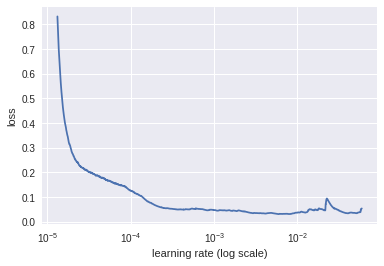

In [87]:
lr = lrOptimizer.determine_lr_rate()
m.sched.plot(100)

##4) Entrenando modelo Base

In [0]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)

In [89]:
m.fit(lr, 1, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe  
    0      16.118437  16.507     67.173901 


[array([16.507]), 67.17390061617779]

###Resultados obtenidos


*Métrica : RMS*

In [90]:
x,y=m.predict_with_targs()
res = exp_rmspe(x,y)
print("resultado modelo: {}".format(res))

resultado modelo: 69.04781730235034


##5) Transferiendo el conocimiento del Modelo Entrenado

In [91]:
from google.colab import files
files.upload()

{}

In [0]:
# move pretrain model
!mv pretrainMarket.md.h5 models/

In [94]:
lr = lrOptimizer.determine_lr_rate()
m.lr_find()

epoch      trn_loss   val_loss   
    0      16.130227  16.507    


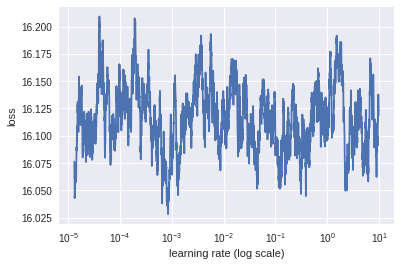

In [95]:
m.sched.plot(100)

In [0]:
mpre = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)

mpre.load('pretrainMarket.md')

In [0]:
#embedding the transfer model into the previously train model
mpre = TransferModel().embed_transfer_model(mpre, m)[0]

In [102]:
mpre.fit(lr, 1, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.00839    0.015447   0.142085  


[array([0.01545]), 0.142084783801501]

### Resultado de Transfer Learning

In [103]:
x,y=mpre.predict_with_targs()
resTransLearn = exp_rmspe(x,y)
print("resultado modelo: {}".format(resTransLearn))

resultado modelo: 0.22650082340627647


Mostrando la diferencia de mejora

In [104]:
#calculo la diferencia entre los modelos
dif = (res- resTransLearn)
print("Diferencia entre modelos {}".format(dif))

Diferencia entre modelos 68.82131647894406


In [0]:
def plot_learning_curve(pipe,name,X_train,y_train,cv=10,linspace=10):
  train_sizes, train_scores, test_scores = learning_curve(estimator=pipe,
                               X=X_train, y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, linspace),
                               cv=cv, n_jobs=-1)

  #calculo los valores de media y desvio estandar por cada CV.
  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)

  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)

  #calculo el proporcional del tamaño del set de entrenamiento
  train_prop = train_sizes / float(len(X_train))

  plt.plot(train_prop, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
  plt.fill_between(train_prop, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

  plt.plot(train_prop, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
  plt.fill_between(train_prop, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

  plt.grid()
  plt.xlabel('% of training samples')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.ylim([0.8, 1.03])
  plt.tight_layout()
  plt.title(name)
  # plt.savefig('learning_curve.png', dpi=300)
  #plt.show()
  return plt

def plot_learning_curves(pipes,names,X_train,y_train,cv=10,linspace=10):
  subplot_number = 223
  plt.figure(1)
  for pipe,name in zip(pipes,names):
    plt.subplot(subplot_number)
    plt = plot_learning_curve(pipe,name,X_train,y_train)
    subplot_number += 1
  plt.show()

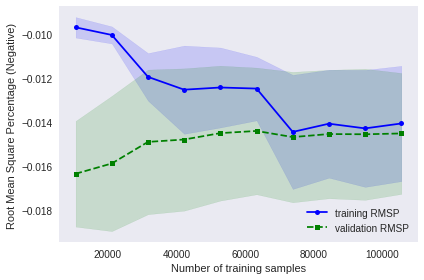

In [107]:
#plotting learning curves
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores =\
                learning_curve(scoring="neg_mean_squared_error",X=x,y=y,estimator=base,train_sizes=np.linspace(0.1, 1.0, 10),cv=2,n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#pylab.rcParams['figure.figsize'] = (8, 8)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training RMSP')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation RMSP')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Root Mean Square Percentage (Negative) ')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()